In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

from xgboost import XGBRegressor, plot_importance

import pickle

plt.rcParams['figure.figsize'] = (15, 8)

In [2]:
data_dir = 'data'
model_dir = 'model'
base_name = 'airTemperature'

In [3]:
df = pd.read_csv(f'../data/{base_name}.csv')
df = df[:-1]
df.head()

,Unnamed: 0,result,table,_start,_stop,_time,_value,_field,_measurement
0,NaN,NaN,0,2024-10-31T12:37:47.815827561Z,2024-11-02T12:37:47.815827561Z,2024-11-01T10:21:00Z,26.550000,airTemperature,first
1,NaN,NaN,0,2024-10-31T12:37:47.815827561Z,2024-11-02T12:37:47.815827561Z,2024-11-01T10:22:00Z,26.600000,airTemperature,first
2,NaN,NaN,0,2024-10-31T12:37:47.815827561Z,2024-11-02T12:37:47.815827561Z,2024-11-01T10:23:00Z,26.600000,airTemperature,first
3,NaN,NaN,0,2024-10-31T12:37:47.815827561Z,2024-11-02T12:37:47.815827561Z,2024-11-01T10:24:00Z,26.651429,airTemperature,first
4,NaN,NaN,0,2024-10-31T12:37:47.815827561Z,2024-11-02T12:37:47.815827561Z,2024-11-01T10:25:00Z,26.700000,airTemperature,first


In [4]:
features_selected = ['_time', '_value']

df = df[features_selected]
df.head()

,_time,_value
0,2024-11-01T10:21:00Z,26.550000
1,2024-11-01T10:22:00Z,26.600000
2,2024-11-01T10:23:00Z,26.600000
3,2024-11-01T10:24:00Z,26.651429
4,2024-11-01T10:25:00Z,26.700000


In [5]:
df.rename(columns={'_time': 'datetime', '_value': f'{base_name}'}, inplace=True)

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [7]:
df.set_index('datetime', inplace=True)

In [8]:
df = df.round({f'{base_name}': 2})
df.head(10)

,airTemperature
datetime,
2024-11-01 10:21:00+00:00,26.55
2024-11-01 10:22:00+00:00,26.60
2024-11-01 10:23:00+00:00,26.60
2024-11-01 10:24:00+00:00,26.65
2024-11-01 10:25:00+00:00,26.70
2024-11-01 10:26:00+00:00,26.70
2024-11-01 10:27:00+00:00,26.69
2024-11-01 10:28:00+00:00,26.69
2024-11-01 10:29:00+00:00,26.77


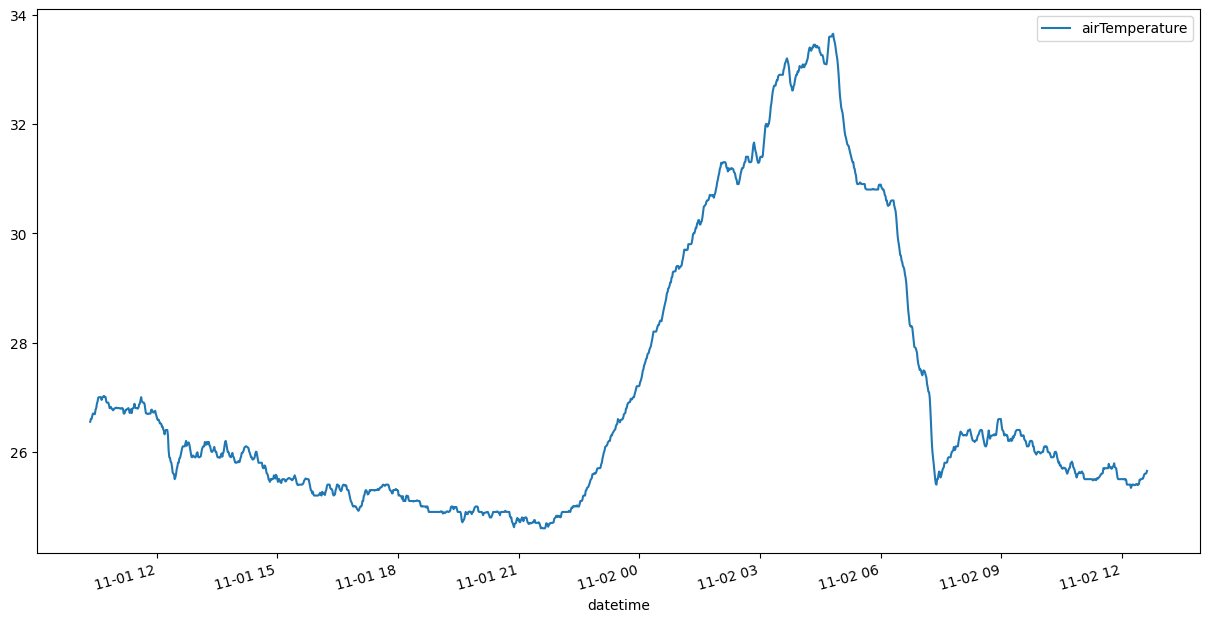

In [9]:
fig, ax = plt.subplots()
df.plot(ax=ax)
plt.xticks(rotation=15)
plt.show()

In [10]:
df.describe()

,airTemperature
count,1576.000000
mean,27.085279
std,2.525441
min,24.600000
25%,25.377500
50%,26.000000
75%,27.912500
max,33.650000


In [11]:
def create_features(data):
    """
    Creates time series features from datetime index
    """
    data['date'] = data.index
    data['minute'] = data['date'].dt.minute
    data['hour'] = data['date'].dt.hour
    data['day'] = data['date'].dt.day
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    data['dayofweek'] = data['date'].dt.dayofweek
    data['dayofyear'] = data['date'].dt.dayofyear
    data['quarter'] = data['date'].dt.quarter
    data['weekofyear'] = data['date'].dt.isocalendar().week

    data = data.drop(columns='date')
    
    return data

In [12]:
df_cf = create_features(df)
df_cf

,airTemperature,minute,hour,day,month,year,dayofweek,dayofyear,quarter,weekofyear
datetime,,,,,,,,,,
2024-11-01 10:21:00+00:00,26.55,21,10,1,11,2024,4,306,4,44
2024-11-01 10:22:00+00:00,26.60,22,10,1,11,2024,4,306,4,44
2024-11-01 10:23:00+00:00,26.60,23,10,1,11,2024,4,306,4,44
2024-11-01 10:24:00+00:00,26.65,24,10,1,11,2024,4,306,4,44
2024-11-01 10:25:00+00:00,26.70,25,10,1,11,2024,4,306,4,44
...,...,...,...,...,...,...,...,...,...,...
2024-11-02 12:33:00+00:00,25.59,33,12,2,11,2024,5,307,4,44
2024-11-02 12:34:00+00:00,25.60,34,12,2,11,2024,5,307,4,44
2024-11-02 12:35:00+00:00,25.60,35,12,2,11,2024,5,307,4,44


In [13]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

df_cf.to_csv(path_or_buf=f"{data_dir}/ready_{base_name}.csv", index=False)

In [14]:
X, y = df_cf.drop(columns=f'{base_name}'), df_cf[f'{base_name}']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

print(f"Number data training \t: {len(y_train)}")
print(f"Number data testing \t: {len(y_test)}")

Number data training 	: 1182
Number data testing 	: 394


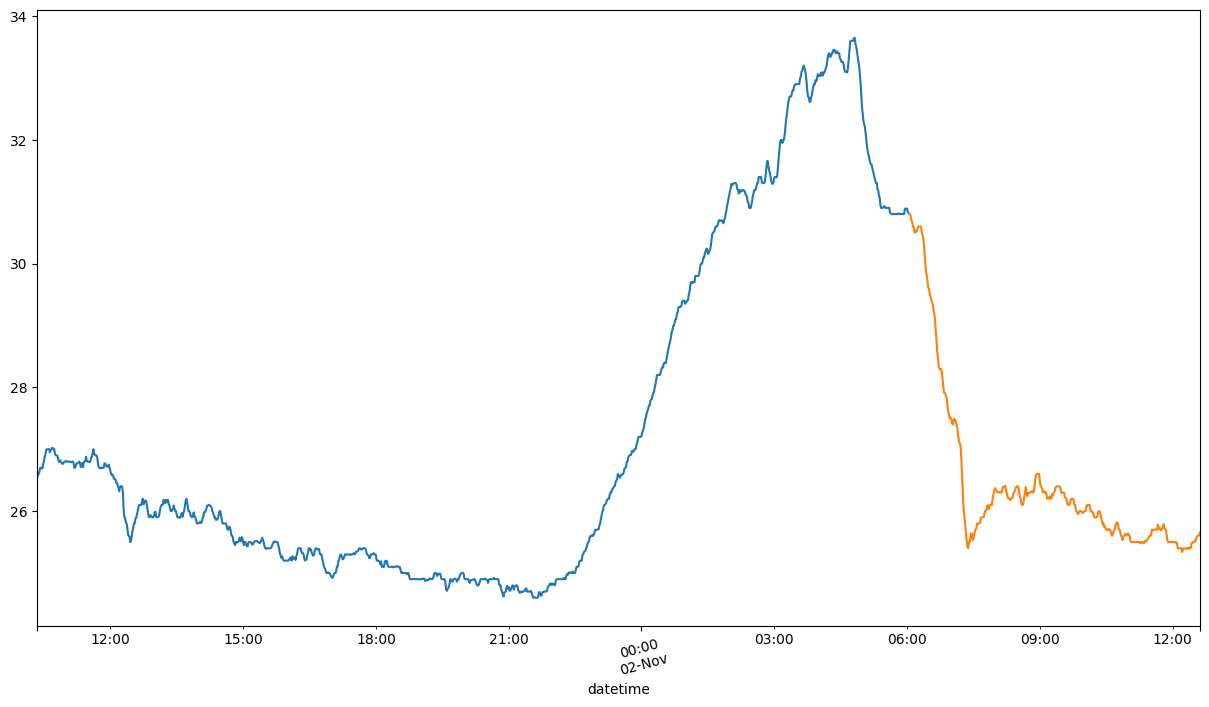

In [16]:
fig, ax = plt.subplots()
y_train.plot(ax=ax)
y_test.plot(ax=ax)
plt.xticks(rotation=15)
plt.show()

Training

In [17]:
params_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth' : [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'n_estimators': [500, 1000, 1500],
}

In [18]:
grid_search = GridSearchCV(XGBRegressor(), params_grid, verbose=3, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8;, score=-4.260 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8;, score=-0.585 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8;, score=-0.462 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8;, score=-1.761 total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8;, score=-1.414 total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.9;, score=-4.268 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.9;, score=-0.589 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.9;, score=-0.456 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_dept

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [500, 1000, 1500],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [19]:
best_params_grid = grid_search.best_params_
best_params_grid, grid_search.best_score_,

({'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 1000,
  'subsample': 1.0},
 np.float64(-1.5892818518887333))

In [20]:
model = XGBRegressor(**best_params_grid)

In [21]:
model.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

pickle.dump(model, open(f"{model_dir}/XGBoost_{base_name}.pkl", "wb"))

In [23]:
model_load = pickle.load(open(f"{model_dir}/XGBoost_{base_name}.pkl", "rb"))

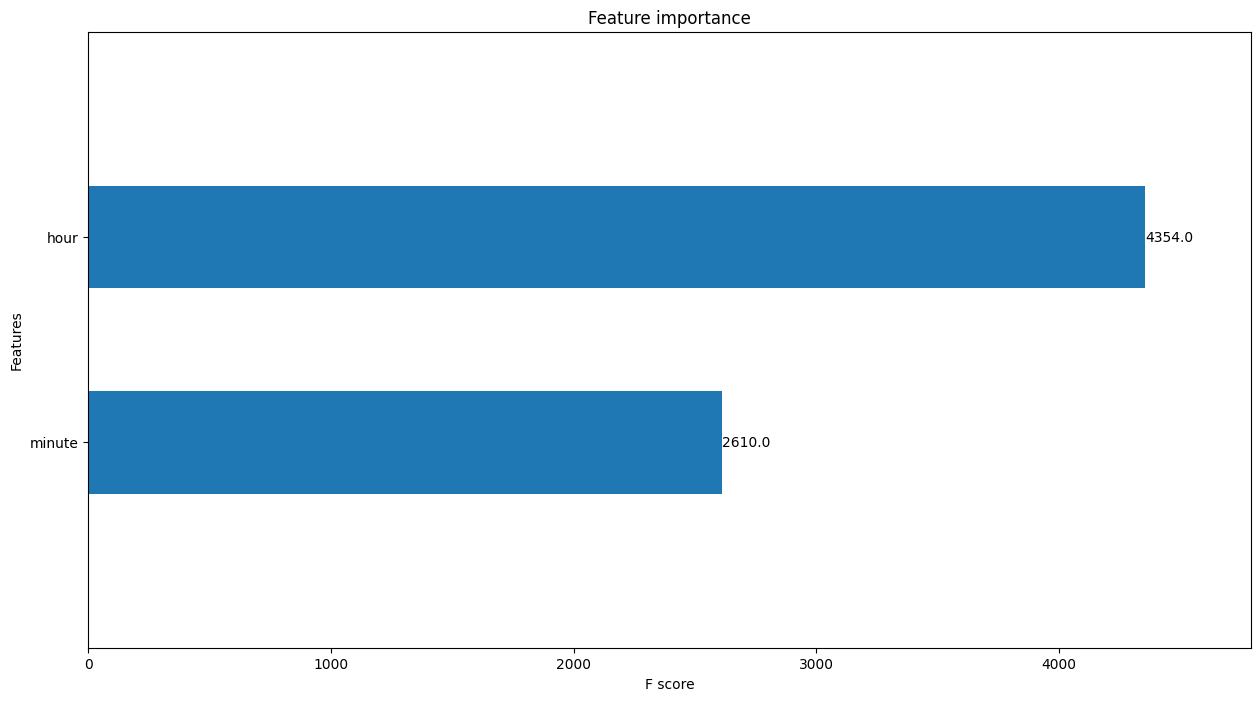

In [24]:
_ = plot_importance(model_load, height=0.5, grid=False)

In [25]:
y_test = pd.DataFrame(y_test)
y_test

,airTemperature
datetime,
2024-11-02 06:03:00+00:00,30.80
2024-11-02 06:04:00+00:00,30.80
2024-11-02 06:05:00+00:00,30.76
2024-11-02 06:06:00+00:00,30.70
2024-11-02 06:07:00+00:00,30.68
...,...
2024-11-02 12:33:00+00:00,25.59
2024-11-02 12:34:00+00:00,25.60
2024-11-02 12:35:00+00:00,25.60


In [26]:
y_test['predict'] = model_load.predict(X_test)

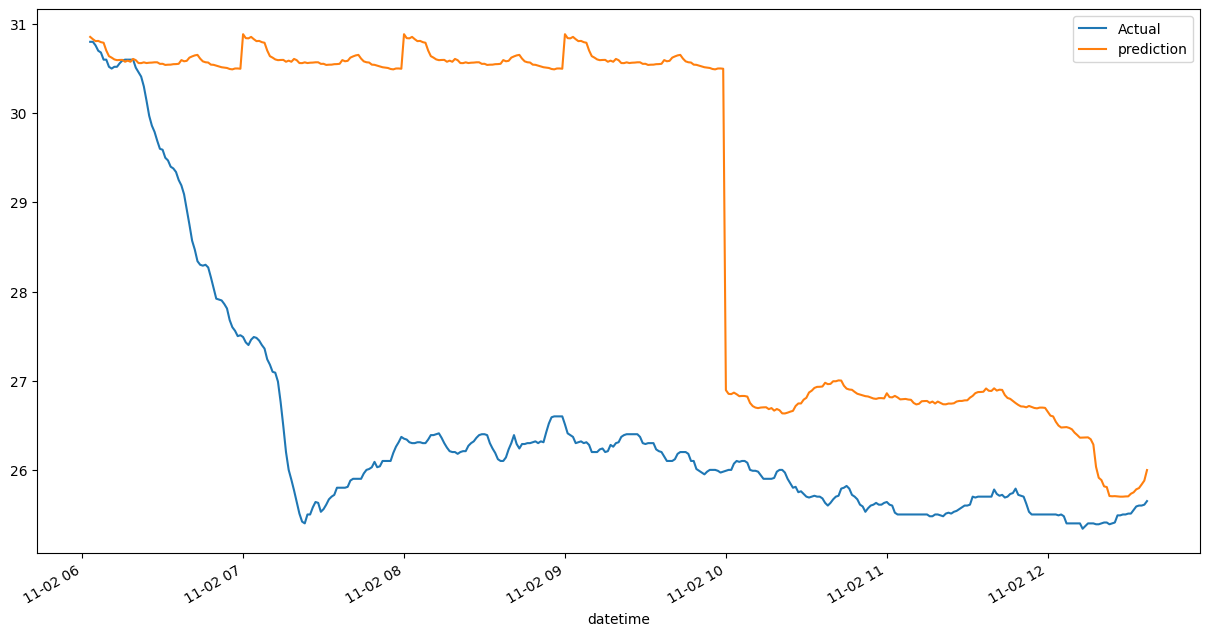

In [27]:
fig, ax = plt.subplots()
y_test.plot(ax=ax)
ax.legend(['Actual', 'prediction'])
plt.show()

In [28]:
mae = mean_absolute_error(y_true=y_test['airTemperature'], y_pred=y_test['predict'])
mape = mean_absolute_percentage_error(y_true=y_test['airTemperature'], y_pred=y_test['predict'])
rmse = root_mean_squared_error(y_true=y_test['airTemperature'], y_pred=y_test['predict'])

print(f"MAE \t: {mae}")
print(f"MAPE \t: {(mape * 100).round(2)}%")
print(f"RMSE \t: {rmse}")

MAE 	: 2.5582783169431735
MAPE 	: 9.74%
RMSE 	: 3.086935677742975
